In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gedsk

In [2]:
from freeqdsk import geqdsk

In [3]:
import scipy.integrate as spi

### Field Following Separatrix Curve Generation Algorithm
#### Introduction
What is Separatrix Curve: Each poloidal field has some saddle points, and the separatrix curve is simply the contour curve, i.e. the points that have the same value of Psi as the saddle point is called the separatrix curve. So, it is very easy to get the separatrix curve by using the contour plot of Psi and this is done in the allCriPoints.ipynb file.

But now, we will use another method to compute the separatrix curve. And it is called the field following method.

#### Field Following Method
The terminologies:

$B$ = Magnetic field <br>
$\psi$ = $B.S$ = Magnetic flux ($Wb$) but in geqdsk file it's $Wb/rad$. <br>
$I$ = plasma current ($A$)<br>
$I_{pol}$ = poloidal current ($A$)<br>

$B_r$ = $-\frac{1}{R} \frac{\partial \psi}{\partial z}$ <br>
$B_z$ = $\frac{1}{R} \frac{\partial \psi}{\partial R}$ <br>
$B_t$ = $\frac{I_{pol}}{R}$ 

$I_{pol}$ is given as a 1D array in the geqdsk file.
<br>

This is described in more detail in Usman's thesis. (available in the TOMMS box folder)


#### Download file if needed

In [110]:
# dowlnoad the geqdsk file
import urllib.request
url = "https://raw.githubusercontent.com/SCOREC/Fusion_Public/master/samples/nstx_132588_v4/g132588.00650"
with urllib.request.urlopen(url) as response:
    with open("download/g132588.00650", 'wb') as f:
        f.write(response.read())

##### Choose the file

In [111]:
# get the data from the file
#filename = r"D:\Codes\AllSamples\N-g127975.00430\g127975.00430"
#filename = "geqdsks\ITER_10MA.geqdsk"
#filename = r"D:\Codes\AllSamples\D-g096333.03337\g096333.03337"
filename = r"D:\Codes\AllSamples\nstx_132588_v4\g132588.00650"
filename = "download/g132588.00650"

In [112]:

data = gedsk.read_gedsk(filename)
wall_points = gedsk.get_wall_points(filename)
psi = gedsk.get_psi(data)
if wall_points is not None:
    print("Wall points found")
else:
    print("Wall points not found")

Wall points found


In [5]:
bounds = gedsk.get_bounds(data)
x, y = gedsk.get_xy(data)
xx, yy = gedsk.get_meshgrid_for_psi(data)
spline = gedsk.get_spline_for_psi(psi, x, y)

In [6]:
lims = data['rlim'], data['zlim']
lims

(array([0.1851, 0.1851, 0.2794, 0.2794, 0.2979, 0.5712, 0.5712, 0.617 ,
        1.194 , 1.0433, 1.3192, 1.3358, 1.4851, 1.4791, 1.5174, 1.5313,
        1.5464, 1.5608, 1.567 , 1.5657, 1.5543, 1.5341, 1.5181, 1.4818,
        1.4851, 1.3358, 1.3192, 1.0433, 1.194 , 0.617 , 0.5712, 0.5712,
        0.2979, 0.2794, 0.2794, 0.1851, 0.1851, 0.1851]),
 array([ 0.    ,  1.0081,  1.1714,  1.578 ,  1.6034,  1.6034,  1.628 ,
         1.628 ,  1.401 ,  1.43  ,  1.0397,  0.9976,  0.545 ,  0.4995,
         0.306 ,  0.2355,  0.1586,  0.0801,  0.    , -0.0177, -0.1123,
        -0.221 , -0.3026, -0.486 , -0.545 , -0.9976, -1.0397, -1.43  ,
        -1.401 , -1.628 , -1.628 , -1.6034, -1.6034, -1.578 , -1.1714,
        -1.0081,  0.    ,  0.    ]))

In [7]:
# now get all the critical points and sort them
all_critical_points = gedsk.find_all_critical_points_using_root(spline, bounds,nx=20, ny=20, method='hybr')

# sort the critical points without using the wall points
sorted_points = gedsk.sort_critical_points(all_critical_points, spline, bounds, None)

# sort the critical points using the wall points
sorted_points_with_wall = gedsk.sort_critical_points(all_critical_points, spline, bounds, lims=lims)

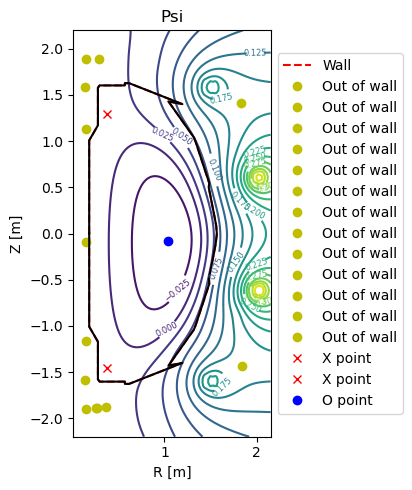

In [8]:
fig, ax = gedsk.plot_sorted_points_with_contour_with_wall(psi, xx, yy, sorted_points_with_wall, filename)
ax.plot(lims[0], lims[1], 'k')
plt.show()

In [9]:
# get the maximum error betweeen spline and the actual psi

# first get the values of psi at all the grid points
psi_values = spline.ev(xx, yy)

# now get the maximum error
max_error = np.max(np.abs(psi_values - psi))
print("Maximum error between spline and psi: ", max_error)

Maximum error between spline and psi:  2.220446049250313e-16


In [10]:
psi_values

array([[3.61946730e-05, 2.56578070e-04, 6.70592169e-04, ...,
        1.04146628e-01, 1.04420732e-01, 1.04685845e-01],
       [4.89474799e-05, 3.48394963e-04, 9.17329631e-04, ...,
        1.06708325e-01, 1.06958257e-01, 1.07199810e-01],
       [6.29920309e-05, 4.49755304e-04, 1.19100785e-03, ...,
        1.09315410e-01, 1.09539227e-01, 1.09755449e-01],
       ...,
       [5.84298282e-05, 4.16782677e-04, 1.10173861e-03, ...,
        1.11085462e-01, 1.11293036e-01, 1.11492693e-01],
       [4.46628045e-05, 3.17429272e-04, 8.33474214e-04, ...,
        1.08419999e-01, 1.08654509e-01, 1.08880390e-01],
       [3.30663826e-05, 2.34228744e-04, 6.11513741e-04, ...,
        1.05800595e-01, 1.06060069e-01, 1.06310363e-01]])

In [11]:
psi

array([[3.61946730e-05, 2.56578070e-04, 6.70592169e-04, ...,
        1.04146628e-01, 1.04420732e-01, 1.04685845e-01],
       [4.89474799e-05, 3.48394963e-04, 9.17329631e-04, ...,
        1.06708325e-01, 1.06958257e-01, 1.07199810e-01],
       [6.29920309e-05, 4.49755304e-04, 1.19100785e-03, ...,
        1.09315410e-01, 1.09539227e-01, 1.09755449e-01],
       ...,
       [5.84298282e-05, 4.16782677e-04, 1.10173861e-03, ...,
        1.11085462e-01, 1.11293036e-01, 1.11492693e-01],
       [4.46628045e-05, 3.17429272e-04, 8.33474214e-04, ...,
        1.08419999e-01, 1.08654509e-01, 1.08880390e-01],
       [3.30663826e-05, 2.34228744e-04, 6.11513741e-04, ...,
        1.05800595e-01, 1.06060069e-01, 1.06310363e-01]])

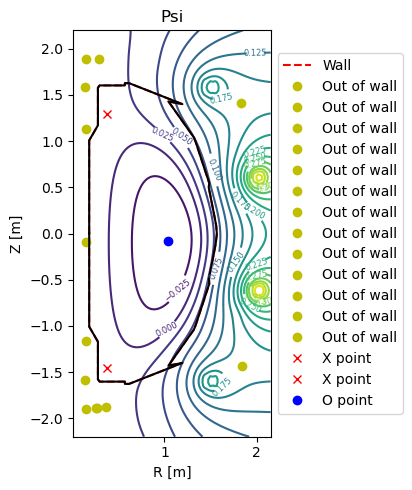

In [12]:
fig, ax = gedsk.plot_sorted_points_with_contour_with_wall(psi_values, xx, yy, sorted_points_with_wall, filename)
ax.plot(lims[0], lims[1], 'k')
plt.show()

#### The Algorithm
Now we have everything to compute the separatrix curve. Now we will use the field following method to compute the separatrix curve.

In [14]:
# get the ipol 1D array and generate the ipol function using interp1d
ipol = data['fpol']

# create a linear interpolation function using the ipol array and map from 0 to 1
# the function gets value from 0 to 1 and returns the value of the ipol at that point
def fpol(x):
    global ipol
    return np.interp(x, np.linspace(0, 1, len(ipol)), ipol)

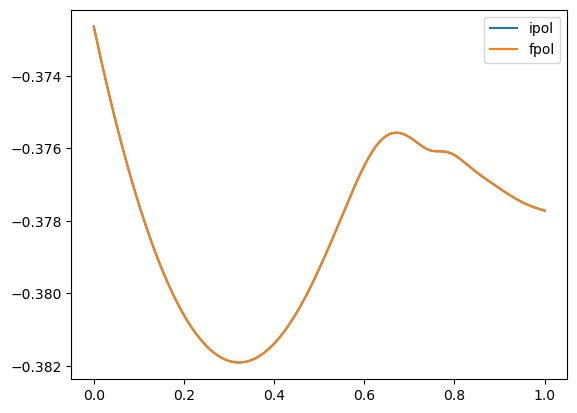

In [16]:
# plot fpol
x = np.linspace(0, 1, len(ipol))
plt.plot(x, ipol, label='ipol')
plt.plot(x, fpol(x), label='fpol')
plt.legend()
plt.show()

In [17]:
sorted_points_with_wall

{'out_of_wall': [(0.15281917809519452, -1.8974665211322421),
  (0.2923535634664241, 1.8929470133383435),
  (0.1491360949023002, -0.0910434736555435),
  (1.827565174074024, 1.4106780629312081),
  (0.3656539433878031, -1.8806332213824843),
  (0.15303431378317975, 1.8903972532910809),
  (0.2723577207609435, -1.8913130926199462),
  (0.1542985219902597, 1.1366029715023294),
  (0.13593872097888904, 1.5839777920391294),
  (0.26407630092974727, -1.891193167462459),
  (0.13697231486357359, -1.5909596610874606),
  (0.15177810242215764, -1.160724726911625),
  (1.8370052516398578, -1.4388573125557007)],
 'saddle': [(0.3788191392029089, 1.29527388742515),
  (0.376016889308171, -1.4591119134083306)],
 'minimum': [(1.0356721235027655, -0.08263432670861574)]}

In [92]:
# create a function that takes the value of psi and normalizes it to 0 to 1
def psi_norm(psivalue):
    global sorted_points_with_wall
    global spline
    x_point = sorted_points_with_wall['saddle'][0]
    minimum_point = sorted_points_with_wall['minimum'][0]
    max_psi = spline(x_point[0], x_point[1])[0][0]
    min_psi = spline(minimum_point[0], minimum_point[1])[0][0]
    # if psivalue is outside the range of psi, change it to the maximum or minimum value
    print("Max psi: ", max_psi)
    print("Min psi: ", min_psi)
    print("Psi value: ", psivalue)
    return (psivalue - min_psi) / (max_psi - min_psi)

In [93]:
# create a get_pol_current function that takes the value of psi and returns the value of the poloidal current at that point
def get_pol_current(psivalue):
    norm_psi = psi_norm(psivalue)
    return fpol(norm_psi)

In [94]:
# get the maximum and minimum of psi and plot the poloidal current
x_point = sorted_points_with_wall['saddle'][1]
o_point = sorted_points_with_wall['minimum'][0]
x_point, o_point

((0.376016889308171, -1.4591119134083306),
 (1.0356721235027655, -0.08263432670861574))

In [106]:
# get the maximum and minimum of psi
max_psi = spline(x_point[0], x_point[1])[0][0]
min_psi = spline(o_point[0], o_point[1])[0][0]
max_psi, min_psi

(0.012397699771564116, -0.04741632291443854)

Max psi:  0.016591510846546243
Min psi:  -0.04741632291443854
Psi value:  [-0.04741632 -0.04681214 -0.04620796 -0.04560378 -0.04499959 -0.04439541
 -0.04379123 -0.04318705 -0.04258287 -0.04197868 -0.0413745  -0.04077032
 -0.04016614 -0.03956196 -0.03895777 -0.03835359 -0.03774941 -0.03714523
 -0.03654105 -0.03593686 -0.03533268 -0.0347285  -0.03412432 -0.03352014
 -0.03291595 -0.03231177 -0.03170759 -0.03110341 -0.03049923 -0.02989504
 -0.02929086 -0.02868668 -0.0280825  -0.02747832 -0.02687413 -0.02626995
 -0.02566577 -0.02506159 -0.02445741 -0.02385322 -0.02324904 -0.02264486
 -0.02204068 -0.02143649 -0.02083231 -0.02022813 -0.01962395 -0.01901977
 -0.01841558 -0.0178114  -0.01720722 -0.01660304 -0.01599886 -0.01539467
 -0.01479049 -0.01418631 -0.01358213 -0.01297795 -0.01237376 -0.01176958
 -0.0111654  -0.01056122 -0.00995704 -0.00935285 -0.00874867 -0.00814449
 -0.00754031 -0.00693613 -0.00633194 -0.00572776 -0.00512358 -0.0045194
 -0.00391522 -0.00331103 -0.00270685 -0.00210267 -0

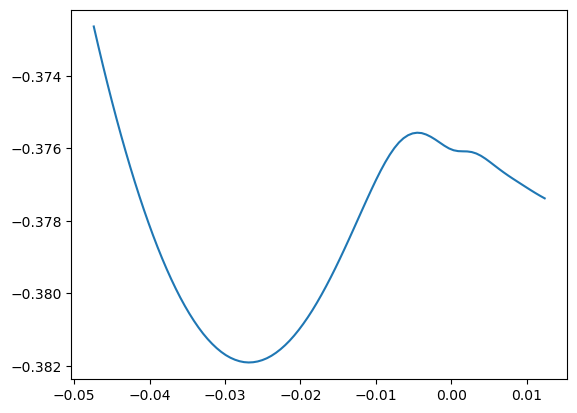

In [107]:
# create a linspace from the minimum to the maximum of psi and get the poloidal current at those points
psi_values = np.linspace(min_psi, max_psi, 100)
pol_current = get_pol_current(psi_values)

# plot the poloidal current
plt.plot(psi_values, pol_current)
plt.show()

### Now do the Line Integrals

In [97]:
def get_dls(t, y):
    R, Z = y
    global spline
    dpsidz = -spline(R, Z, dx=0, dy=1)[0][0]
    dpsidr = spline(R, Z, dx=1, dy=0)[0][0]
    psi = spline(R, Z)[0][0]
    I = get_pol_current(psi)
    #return (dpsidz * R) / I, (dpsidr * R) / I
    return (dpsidz) / I, (dpsidr) / I


In [98]:
# now do the integration of the dls and plot the field lines
R0 = sorted_points_with_wall['saddle'][1][0]
Z0 = sorted_points_with_wall['saddle'][1][1]

In [99]:
R0, Z0

(0.376016889308171, -1.4591119134083306)

In [100]:
sol = spi.solve_ivp(get_dls, (0, 100), (R0, Z0), t_eval=np.linspace(0, 100, 50))

Max psi:  0.016591510846546243
Min psi:  -0.04741632291443854
Psi value:  0.012397699771564116
Max psi:  0.016591510846546243
Min psi:  -0.04741632291443854
Psi value:  0.012397699771564116
Max psi:  0.016591510846546243
Min psi:  -0.04741632291443854
Psi value:  0.012397699771564116
Max psi:  0.016591510846546243
Min psi:  -0.04741632291443854
Psi value:  0.012397699771564116
Max psi:  0.016591510846546243
Min psi:  -0.04741632291443854
Psi value:  0.012397699771564116
Max psi:  0.016591510846546243
Min psi:  -0.04741632291443854
Psi value:  0.012397699771564116
Max psi:  0.016591510846546243
Min psi:  -0.04741632291443854
Psi value:  0.012397699771564116
Max psi:  0.016591510846546243
Min psi:  -0.04741632291443854
Psi value:  0.012397699771564116
Max psi:  0.016591510846546243
Min psi:  -0.04741632291443854
Psi value:  0.012397699771564116
Max psi:  0.016591510846546243
Min psi:  -0.04741632291443854
Psi value:  0.012397699771564116
Max psi:  0.016591510846546243
Min psi:  -0.047416

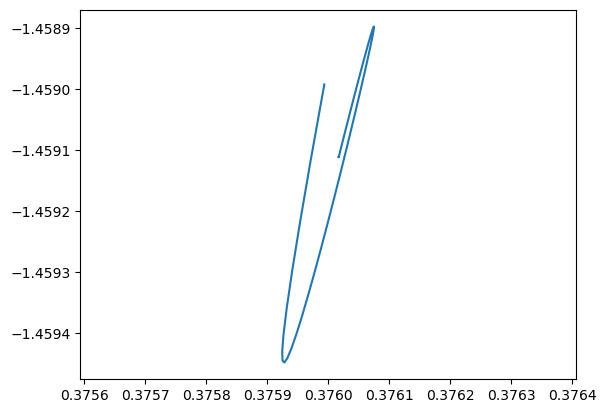

In [101]:
r, z = sol.y
plt.plot(r, z)
# equal aspect ratio
plt.axis('equal')
plt.show()

In [102]:
sol

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  2.041e+00 ...  9.796e+01  1.000e+02]
        y: [[ 3.760e-01  3.760e-01 ...  3.760e-01  3.760e-01]
            [-1.459e+00 -1.459e+00 ... -1.459e+00 -1.459e+00]]
      sol: None
 t_events: None
 y_events: None
     nfev: 44
     njev: 0
      nlu: 0

In [103]:
# let's implement the field line following algorithm manually
r_sep = []
z_sep = []

def next_step(r, z, dls, step_size):
    dr, dz = dls(r, z)
    dr *= step_size
    dz *= step_size
    return r + dr, z + dz

In [104]:
def manual_dls(R,Z):
    global spline
    dpsidz = -spline(R, Z, dx=0, dy=1)[0][0]
    dpsidr = spline(R, Z, dx=1, dy=0)[0][0]
    psi = spline(R, Z)[0][0]
    I = get_pol_current(psi)
    return (dpsidz * R) / I, (dpsidr * R) / I
    #return (dpsidz) / I, (dpsidr) / I

for i in range(100):
    r, z = next_step(r, z, manual_dls, 0.1)
    r_sep.append(r)
    z_sep.append(z)

plt.plot(r_sep, z_sep)


In [ ]:
r_sep

[0.376016889308171]